In [1]:
import os

BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"

print("Malayalam dep train:", len(os.listdir(BASE + "/Malayalam/Malayalam/Depressed/Train_set")))
print("Malayalam nondep train:", len(os.listdir(BASE + "/Malayalam/Malayalam/Non_depressed/Train_set")))
print("Tamil dep train:", len(os.listdir(BASE + "/Tamil/Tamil/Depressed/Train_set")))
print("Tamil nondep train:", len(os.listdir(BASE + "/Tamil/Tamil/Non-depressed/Train_set")))
print("Malayalam test:", len(os.listdir(BASE + "/Test_set_mal/Test_set_mal")))
print("Tamil test:", len(os.listdir(BASE + "/Test-set-tamil/Test-set-tamil")))

Malayalam dep train: 788
Malayalam nondep train: 900
Tamil dep train: 454
Tamil nondep train: 920
Malayalam test: 200
Tamil test: 160


# Reproducibility

Random seeds are fixed for Python, NumPy, and PyTorch to ensure deterministic and reproducible results. CUDA determinism is enabled, and a worker seed function is used for DataLoader consistency

In [3]:
import os, random
import numpy as np
import torch

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Resampling

Resamples Malayalam depression dataset audio to 16 kHz mono while preserving folder structure and logging errors.

In [4]:
import os, glob, logging
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm


# Paths (Kaggle)

BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"
RAW_ROOT = os.path.join(BASE, "Malayalam", "Malayalam")      # contains Depressed/ and Non_depressed/
OUT_ROOT = "/kaggle/working/data/Malayalam_16k"              # writable output
os.makedirs(OUT_ROOT, exist_ok=True)


# Logging
logging.basicConfig(
    filename="resample_errors.log",
    level=logging.ERROR,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

def resample_audio(in_path, out_path, target_sr=16000):
    try:
        y, sr = librosa.load(in_path, sr=None, mono=True)

        if y is None or len(y) == 0:
            raise ValueError("Empty audio")

        if float(np.sqrt(np.mean(y**2))) < 1e-6:
            raise ValueError("Near-silent audio")

        if sr != target_sr:
            try:
                y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="soxr_hq")
            except Exception:
                y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")

        y = np.clip(y, -1.0, 1.0)

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        sf.write(out_path, y, target_sr)

    except Exception as e:
        logging.error(f"Error processing {in_path}: {e}")
        print(f"[Resample error] {in_path} -> {e}")

def process_folder(src_folder, dst_folder):
    wav_files = glob.glob(os.path.join(src_folder, "**/*.wav"), recursive=True)
    if len(wav_files) == 0:
        print(f"[Skip] No wav files found in: {src_folder}")
        return

    for in_path in tqdm(wav_files, desc=f"Resampling {os.path.basename(src_folder)}"):
        
        rel = os.path.relpath(in_path, src_folder)
        out_path = os.path.join(dst_folder, rel)

        if os.path.exists(out_path):
            continue

        resample_audio(in_path, out_path, target_sr=16000)

pairs = [
    ("Depressed", "Depressed"),
    ("Non_depressed", "Non_depressed"),
]

for src_sub, dst_sub in pairs:
    src_path = os.path.join(RAW_ROOT, src_sub)
    dst_path = os.path.join(OUT_ROOT, dst_sub)
    process_folder(src_path, dst_path)
print("\n Resampling complete. Output root:", OUT_ROOT)



Resampling Non_depressed: 100%|██████████| 900/900 [00:24<00:00, 36.51it/s]


 Resampling complete. Output root: /kaggle/working/data/Malayalam_16k


# Creating Metadata CSV

In [5]:
import os, glob
import pandas as pd

DATA_ROOT = "/kaggle/working/data/Malayalam_16k"

rows = []
def collect(folder, label):
    files = glob.glob(os.path.join(folder, "**/*.wav"), recursive=True)
    for f in files:
        rows.append({
            "file_path": f,
            "label": label,
            "fname": os.path.splitext(os.path.basename(f))[0]
        })
collect(os.path.join(DATA_ROOT, "Depressed"), 1)
collect(os.path.join(DATA_ROOT, "Non_depressed"), 0)
df = pd.DataFrame(rows)
assert len(df) > 0, "No wav files found."

# Deterministic shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

metadata_path = os.path.join(DATA_ROOT, "malayalam_metadata.csv")
df.to_csv(metadata_path, index=False)

print("CSV saved at:", metadata_path)
print(df.head())
print("\n Label counts:")
print(df["label"].value_counts())
print("\n Total files:", len(df))

CSV saved at: /kaggle/working/data/Malayalam_16k/malayalam_metadata.csv
                                           file_path  label        fname
0  /kaggle/working/data/Malayalam_16k/Non_depress...      0     ND5_0165
1  /kaggle/working/data/Malayalam_16k/Depressed/T...      1  D_F001_41_4
2  /kaggle/working/data/Malayalam_16k/Depressed/T...      1  D_F001_13_2
3  /kaggle/working/data/Malayalam_16k/Depressed/T...      1  D_F001_12_4
4  /kaggle/working/data/Malayalam_16k/Non_depress...      0     ND5_0166

 Label counts:
label
0    900
1    788
Name: count, dtype: int64

 Total files: 1688


# Sanity Check of Data

In [6]:
import os, re
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit


# Load metadata
DATA_ROOT = "/kaggle/working/data/Malayalam_16k"
csv_path = os.path.join(DATA_ROOT, "malayalam_metadata.csv")
df = pd.read_csv(csv_path)
print("Loaded CSV:", len(df))


# Speaker & utterance parsing 
def extract_speaker(fname):
   
    parts = fname.split("_")
    if fname.startswith("ND"):
        return parts[0]            # ND1, ND3, ...
    if fname.startswith("D_"):
        return "_".join(parts[:2]) # D_F001, D_A032, ...
    return parts[0]                # fallback

def extract_utt_base(fname):
  
    return re.sub(r"_\d+$", "", fname)

df["speaker"] = df["fname"].apply(extract_speaker)
df["utt_base"] = df["fname"].apply(extract_utt_base)


# Basic dataset stats
print("\n[Label distribution]")
print(df["label"].value_counts())

print("\n[Unique speakers per class]")
print(df.groupby("label")["speaker"].nunique().rename({0:"Non-depressed", 1:"Depressed"}))
print("\n[Top speakers by sample count]")
print(df["speaker"].value_counts().head(10))


# Repeat-utterance analysis

repeat_counts = (
    df.groupby(["speaker", "utt_base"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

repeats = repeat_counts[repeat_counts["count"] > 1]

print("\n[Repeated utterances by same speaker]")
print("Number of repeated (speaker, utt_base) pairs:", len(repeats))
if len(repeats) > 0:
    print(repeats.head(10))


# Audio health checks
def audio_stats(path):
    try:
        info = sf.info(path)
        sr = info.samplerate
        dur = info.frames / float(sr)

        y, _ = sf.read(path, dtype="float32", always_2d=False)
        if y.ndim > 1:
            y = np.mean(y, axis=1)

        sil_ratio = float(np.mean(np.abs(y) < 1e-4))
        rms = float(np.sqrt(np.mean(y**2)) + 1e-12)

        return sr, dur, sil_ratio, rms, None
    except Exception as e:
        return None, None, None, None, str(e)

rows = []
for p in tqdm(df["file_path"], desc="Scanning audio"):
    rows.append(audio_stats(p))

df[["sr","dur_sec","sil_ratio","rms","err"]] = pd.DataFrame(rows, index=df.index)

print("\n[Read errors]:", df["err"].notna().sum())

print("\n[Sample rate distribution]")
print(df["sr"].value_counts())

print("\n[Duration stats (sec)]")
print(df["dur_sec"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

print("\n[Silence ratio stats]")
print(df["sil_ratio"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

print("\n[Potential issues]")
print("Too short (<0.3s):", (df["dur_sec"] < 0.3).sum())
print("Very silent (sil_ratio > 0.98):", (df["sil_ratio"] > 0.98).sum())


# Speaker-safe split simulation

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, y=df["label"], groups=df["speaker"]))

train_df = df.iloc[train_idx]
val_df   = df.iloc[val_idx]

speaker_overlap = set(train_df["speaker"]).intersection(set(val_df["speaker"]))
utt_overlap = set(zip(train_df["speaker"], train_df["utt_base"])) & \
              set(zip(val_df["speaker"], val_df["utt_base"]))

print("\n[Speaker-safe split check]")
print("Train speakers:", train_df["speaker"].nunique())
print("Val speakers:", val_df["speaker"].nunique())
print("Speaker overlap:", len(speaker_overlap))

print("Overlap of (speaker, utt_base) across splits:", len(utt_overlap))
if len(utt_overlap) > 0:
    print("Example overlaps:", list(utt_overlap)[:10])

print("\n Sanity check done.")


Loaded CSV: 1688

[Label distribution]
label
0    900
1    788
Name: count, dtype: int64

[Unique speakers per class]
label
Non-depressed      5
Depressed        127
Name: speaker, dtype: int64

[Top speakers by sample count]
speaker
D_F001     284
ND5        180
ND3        180
ND4        180
ND2        180
ND1        180
D_S0035      4
D_S0053      4
D_S0021      4
D_A044       4
Name: count, dtype: int64

[Repeated utterances by same speaker]
Number of repeated (speaker, utt_base) pairs: 138
    speaker utt_base  count
389     ND1      ND1    180
392     ND4      ND4    180
390     ND2      ND2    180
391     ND3      ND3    180
393     ND5      ND5    180
28   D_A029   D_A029      4
26   D_A027   D_A027      4
27   D_A028   D_A028      4
24   D_A025   D_A025      4
25   D_A026   D_A026      4


Scanning audio: 100%|██████████| 1688/1688 [00:01<00:00, 1426.74it/s]


[Read errors]: 0

[Sample rate distribution]
sr
16000    1688
Name: count, dtype: int64

[Duration stats (sec)]
count    1688.000000
mean        4.714041
std         1.417860
min         1.522625
1%          1.979884
5%          2.449813
50%         4.644813
95%         6.943516
99%         8.261785
max        10.360875
Name: dur_sec, dtype: float64

[Silence ratio stats]
count    1688.000000
mean        0.052202
std         0.100364
min         0.000746
1%          0.000975
5%          0.001190
50%         0.005252
95%         0.294750
99%         0.388547
max         0.579842
Name: sil_ratio, dtype: float64

[Potential issues]
Too short (<0.3s): 0
Very silent (sil_ratio > 0.98): 0

[Speaker-safe split check]
Train speakers: 105
Val speakers: 27
Speaker overlap: 0
Overlap of (speaker, utt_base) across splits: 0

 Sanity check done.


In [7]:
import re
import pandas as pd

df = pd.read_csv("/kaggle/working/data/Malayalam_16k/malayalam_metadata.csv")

def extract_speaker(fname):
    # Non-depressed speakers: ND1, ND2
    m = re.match(r"^(ND\d+)_", fname, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()

    
    m = re.match(r"^(D)_([FMS]\d{3})_", fname, flags=re.IGNORECASE)
    if m:
        return f"{m.group(1).upper()}_{m.group(2).upper()}"

    # If it's depressed but doesn't match known speaker pattern, 
    if fname.upper().startswith("D_"):
        return "D_OTHER"

    return "UNKNOWN"

def extract_utt_base(fname):
    # remove trailing repeat suffix
    return re.sub(r"_\d+$", "", fname.upper())

df["speaker_fixed"] = df["fname"].apply(extract_speaker)
df["utt_base_fixed"] = df["fname"].apply(extract_utt_base)

print("Unique speakers per class (fixed):")
print(df.groupby("label")["speaker_fixed"].nunique().rename({0:"Non-depressed", 1:"Depressed"}))

print("\nTop speakers (fixed):")
print(df["speaker_fixed"].value_counts().head(20))

print("\nHow many D_OTHER?")
print((df["speaker_fixed"]=="D_OTHER").sum())


Unique speakers per class (fixed):
label
Non-depressed     5
Depressed        11
Name: speaker_fixed, dtype: int64

Top speakers (fixed):
speaker_fixed
D_OTHER    477
D_F001     284
ND3        180
ND5        180
ND4        180
ND2        180
ND1        180
D_S005       3
D_S009       3
D_S007       3
D_S006       3
D_S003       3
D_S002       3
D_S008       3
D_S001       3
D_S004       3
Name: count, dtype: int64

How many D_OTHER?
477


# Speaker-Aware Leakage-Free Train–Validation Split
Creates speaker-aware, leakage-free stratified train–validation splits for the Malayalam dataset using grouped cross-validation.

In [8]:
import os, re
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold


IN_PATH  = "/kaggle/working/data/Malayalam_16k/malayalam_metadata.csv"
OUT_PATH = "/kaggle/working/data/Malayalam_16k/malayalam_metadata_with_split.csv"

df = pd.read_csv(IN_PATH)
def extract_speaker(fname: str) -> str:
    
    base = os.path.basename(str(fname))
    stem = os.path.splitext(base)[0]  # remove .wav/.WAV etc
    s = stem.upper()

    # ND speakers: 
    m = re.match(r"^(ND\d+)_", s)
    if m:
        return m.group(1)

    # Depressed explicit:
    m = re.match(r"^(D)_([A-Z]\d{3,4})_", s)
    if m:
        return f"{m.group(1)}_{m.group(2)}"

    
    # This prevents collapsing many files into D_OTHER if token exists.
    m = re.match(r"^(D)_(.+?)_", s)
    if m:
        token = re.sub(r"[^A-Z0-9]+", "", m.group(2))  # sanitize
        if token:
            return f"D_{token}"

    # If it starts with D_ but no second underscore 
    if s.startswith("D_"):
        return "D_UNK"

    return "UNKNOWN"


def utt_base(fname: str) -> str:
    
    base = os.path.basename(str(fname))
    stem = os.path.splitext(base)[0].upper()    
    stem = re.sub(r"(_SEG)?_?\d{1,4}$", "", stem)                  
    stem = re.sub(r"_(CHUNK|PART|CLIP|UTT|SEGMENT)_?\d{1,4}$", "", stem)

    return stem


df["speaker_fixed"] = df["fname"].apply(extract_speaker)
df["utt_base_fixed"] = df["fname"].apply(utt_base)


# Grouping strategy

def make_group(row):
   
    spk = row["speaker_fixed"]
    if spk in ("UNKNOWN", "D_UNK"):
        return "UTT_" + row["utt_base_fixed"]
    return spk

df["group_id"] = df.apply(make_group, axis=1)


# Basic sanity checks (compliance)

print("Loaded CSV:", len(df))
print("\n[Label distribution]")
print(df["label"].value_counts())

print("\n[Top speakers]")
print(df["speaker_fixed"].value_counts().head(20))

unknown_rate = (df["speaker_fixed"].isin(["UNKNOWN", "D_UNK"])).mean()
print(f"\nUNKNOWN/D_UNK rate: {unknown_rate:.3f}")
# If too many unknowns, parsing likely wrong 
if unknown_rate > 0.05:
    print("Many UNKNOWN/D_UNK speakers.")

overall_ratio = df["label"].mean()
print("\nOverall depressed ratio:", overall_ratio)


# StratifiedGroupKFold split

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

candidates = []
X = np.zeros((len(df), 1))  # dummy features

for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, df["label"], groups=df["group_id"])):
    val = df.iloc[val_idx]
    train = df.iloc[train_idx]

    val_counts = val["label"].value_counts().to_dict()
    train_counts = train["label"].value_counts().to_dict()

    val_size = len(val)
    has_both = (0 in val_counts) and (1 in val_counts)
    val_ratio = val["label"].mean() if val_size > 0 else 0.0

    score = abs(val_ratio - overall_ratio)
    if not has_both:
        score += 10.0
    # keep val reasonably sized 
    if val_size < 200:
        score += (200 - val_size) / 50.0

    candidates.append((score, fold, val_size, val_counts, val_ratio, train_counts))

print("\nFold candidates:")
for score, fold, val_size, val_counts, val_ratio, train_counts in sorted(candidates, key=lambda x: x[0]):
    print(f"fold={fold}  score={score:.3f}  val_size={val_size}  val_counts={val_counts}  val_ratio={val_ratio:.3f}")

best = sorted(candidates, key=lambda x: x[0])[0]
_, best_fold, *_ = best
print("\n Choosing best fold:", best_fold)

# rerun to get indices for chosen fold
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, df["label"], groups=df["group_id"])):
    if fold == best_fold:
        break

df["split"] = "train"
df.loc[val_idx, "split"] = "val"


# Compliance verification

train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]

group_overlap = set(train_df["group_id"]) & set(val_df["group_id"])
speaker_overlap = set(train_df["speaker_fixed"]) & set(val_df["speaker_fixed"])

print("\nGroup overlap:", len(group_overlap))
print("Speaker overlap:", len(speaker_overlap))

# Extra: prevent exact same utt_base overlap 
utt_overlap = set(train_df["utt_base_fixed"]) & set(val_df["utt_base_fixed"])
print("Utt_base overlap:", len(utt_overlap))

print("\nTrain label counts:")
print(train_df["label"].value_counts(), " Train ratio:", train_df["label"].mean())

print("\nVal label counts:")
print(val_df["label"].value_counts(), " Val ratio:", val_df["label"].mean())


# Save

df.to_csv(OUT_PATH, index=False)
print("\n Saved split CSV:", OUT_PATH)

Loaded CSV: 1688

[Label distribution]
label
0    900
1    788
Name: count, dtype: int64

[Top speakers]
speaker_fixed
D_F001    284
ND5       180
ND3       180
ND4       180
ND2       180
ND1       180
D_UNK      64
D_A013      4
D_A021      4
D_A034      4
D_A006      4
D_A002      4
D_A044      4
D_A029      4
D_A001      4
D_A037      4
D_A045      4
D_A056      4
D_A035      4
D_A016      4
Name: count, dtype: int64

UNKNOWN/D_UNK rate: 0.038

Overall depressed ratio: 0.466824644549763

Fold candidates:
fold=3  score=0.053  val_size=307  val_counts={0: 180, 1: 127}  val_ratio=0.414
fold=2  score=0.059  val_size=759  val_counts={1: 399, 0: 360}  val_ratio=0.526
fold=1  score=0.314  val_size=425  val_counts={0: 360, 1: 65}  val_ratio=0.153
fold=4  score=10.733  val_size=190  val_counts={1: 190}  val_ratio=1.000
fold=0  score=14.393  val_size=7  val_counts={1: 7}  val_ratio=1.000

 Choosing best fold: 3

Group overlap: 0
Speaker overlap: 0
Utt_base overlap: 0

Train label counts:
lab

# MFCC

In [14]:


import os, random, json
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight


SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id: int):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_ROOT = "/kaggle/working/data/Malayalam_16k"  # change if needed
SPLIT_CSV = os.path.join(DATA_ROOT, "malayalam_metadata_with_split.csv")

# output files
OUT_DIR = "/kaggle/working"
MODEL_PT = os.path.join(OUT_DIR, "mfcc_mlp.pt")
META_JSON = os.path.join(OUT_DIR, "mfcc_mlp_meta.json")
VAL_PRED_CSV = os.path.join(OUT_DIR, "mfcc_val_preds.csv")

assert os.path.isfile(SPLIT_CSV), f"Missing split CSV: {SPLIT_CSV}"

# MFCC params (keep these consistent for train/val/test)
SR = 16000
MAX_SECONDS = 6
N_MFCC = 20
MAX_FRAMES = 120
N_FFT = 400
HOP_LENGTH = 160

# training params
BATCH_TRAIN = 32
BATCH_VAL = 64
NUM_WORKERS = 2

LR = 5e-4
WEIGHT_DECAY = 1e-2
EPOCHS = 30
PATIENCE = 5
GRAD_CLIP = 1.0

# augmentation (only on train)
AUG_PROB = 0.6
MAX_TIME_MASK = 12
MAX_FREQ_MASK = 4

# model
HIDDEN = 128
DROPOUT = 0.5


df = pd.read_csv(SPLIT_CSV)
required_cols = {"file_path", "label", "split"}
missing_cols = required_cols - set(df.columns)
assert not missing_cols, f"Split CSV missing columns: {missing_cols}. Found: {list(df.columns)}"

# basic sanitize
df["file_path"] = df["file_path"].astype(str)
df["split"] = df["split"].astype(str)
df["label"] = df["label"].astype(int)

# check files exist
bad_paths = df[~df["file_path"].apply(os.path.exists)]
print("Missing audio rows:", len(bad_paths))
if len(bad_paths) > 0:
    print(bad_paths[["file_path", "label", "split"]].head(10))
df = df[df["file_path"].apply(os.path.exists)].reset_index(drop=True)

train_df = df[df["split"].str.lower() == "train"].reset_index(drop=True)
val_df   = df[df["split"].str.lower() == "val"].reset_index(drop=True)

assert len(train_df) > 0, "No train rows found in split CSV."
assert len(val_df) > 0, "No val rows found in split CSV."

print("Train:", len(train_df), "| Val:", len(val_df))
print("Train label counts:\n", train_df["label"].value_counts())
print("Val label counts:\n", val_df["label"].value_counts())


def extract_mfcc_2d(
    file_path: str,
    sr: int = SR,
    n_mfcc: int = N_MFCC,
    max_frames: int = MAX_FRAMES,
    n_fft: int = N_FFT,
    hop_length: int = HOP_LENGTH,
    max_seconds: int = MAX_SECONDS,
) -> np.ndarray:
    y, _ = librosa.load(file_path, sr=sr, mono=True)

    # truncate to fixed seconds
    max_samples = int(sr * max_seconds)
    if len(y) > max_samples:
        y = y[:max_samples]

    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=n_mfcc,
        n_fft=n_fft, hop_length=hop_length
    )  # (n_mfcc, T)

    # pad/truncate time axis
    T = mfcc.shape[1]
    if T < max_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_frames]

    # per-sample normalize
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)
    return mfcc.astype(np.float32)

def time_freq_mask(
    mfcc_2d: np.ndarray,
    max_time_mask: int = MAX_TIME_MASK,
    max_freq_mask: int = MAX_FREQ_MASK,
    p: float = AUG_PROB
) -> np.ndarray:
    # light SpecAugment-style masking
    if random.random() > p:
        return mfcc_2d

    mfcc = mfcc_2d.copy()
    n_mfcc, T = mfcc.shape

    # time mask
    t = random.randint(0, max_time_mask)
    if t > 0:
        t0 = random.randint(0, max(0, T - t))
        mfcc[:, t0:t0 + t] = 0.0

    # freq mask
    f = random.randint(0, max_freq_mask)
    if f > 0:
        f0 = random.randint(0, max(0, n_mfcc - f))
        mfcc[f0:f0 + f, :] = 0.0

    return mfcc


class MFCCDataset(Dataset):
    def __init__(self, df_: pd.DataFrame, augment: bool = False):
        self.df = df_.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        path = row["file_path"]
        label = int(row["label"])

        mfcc = extract_mfcc_2d(path)
        if self.augment:
            mfcc = time_freq_mask(mfcc)

        # flatten for MLP
        x = torch.tensor(mfcc.reshape(-1), dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.long)
        return x, y

train_ds = MFCCDataset(train_df, augment=True)
val_ds   = MFCCDataset(val_df, augment=False)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_TRAIN,
    shuffle=True,
    num_workers=NUM_WORKERS,
    worker_init_fn=seed_worker,
    generator=g,
    pin_memory=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_VAL,
    shuffle=False,
    num_workers=NUM_WORKERS,
    worker_init_fn=seed_worker,
    generator=g,
    pin_memory=True,
)


train_labels = train_df["label"].values
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights.detach().cpu().numpy())


INPUT_DIM = N_MFCC * MAX_FRAMES

class MFCC_MLP(nn.Module):
    def __init__(self, input_dim: int = INPUT_DIM, hidden: int = HIDDEN, drop: float = DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 2),
        )

    def forward(self, x):
        return self.net(x)

model = MFCC_MLP().to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


best_f1 = -1.0
best_state = None
bad = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()

        if GRAD_CLIP is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        optimizer.step()
        total_loss += float(loss.item())

    train_loss = total_loss / max(1, len(train_loader))

    # validate
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            p = torch.argmax(logits, dim=1)
            preds.extend(p.detach().cpu().numpy().tolist())
            gold.extend(y.detach().cpu().numpy().tolist())

    val_f1 = f1_score(gold, preds, average="macro")
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_macroF1={val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1 = float(val_f1)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping.")
            break

assert best_state is not None, "best_state is None — something went wrong (no improvement on val)."

# load best
model.load_state_dict(best_state)
print("\n Best MFCC Val macro-F1:", best_f1)

# -----------------------------
# 8) Save weights + metadata
# -----------------------------
torch.save(best_state, MODEL_PT)
print("Saved MFCC weights:", MODEL_PT)

meta = {
    "seed": SEED,
    "sr": SR,
    "max_seconds": MAX_SECONDS,
    "n_mfcc": N_MFCC,
    "max_frames": MAX_FRAMES,
    "n_fft": N_FFT,
    "hop_length": HOP_LENGTH,
    "input_dim": INPUT_DIM,
    "hidden": HIDDEN,
    "dropout": DROPOUT,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "batch_train": BATCH_TRAIN,
    "batch_val": BATCH_VAL,
    "epochs_max": EPOCHS,
    "patience": PATIENCE,
    "grad_clip": GRAD_CLIP,
    "augment_prob": AUG_PROB,
    "max_time_mask": MAX_TIME_MASK,
    "max_freq_mask": MAX_FREQ_MASK,
    "best_val_macro_f1": best_f1,
    "split_csv": SPLIT_CSV,
}
with open(META_JSON, "w") as f:
    json.dump(meta, f, indent=2)
print(" Saved meta:", META_JSON)

# -----------------------------
# 9) Save VAL predictions (so report can be reproduced without retraining)
# -----------------------------
val_preds_df = val_df.copy()
val_preds_df["pred"] = preds
val_preds_df.to_csv(VAL_PRED_CSV, index=False)
print("Saved val predictions:", VAL_PRED_CSV)

print("\nVAL Classification Report:")
print(classification_report(gold, preds, digits=4, target_names=["Non-Depressed(0)", "Depressed(1)"]))

Device: cuda
Missing audio rows: 0
Train: 1381 | Val: 307
Train label counts:
 label
0    720
1    661
Name: count, dtype: int64
Val label counts:
 label
0    180
1    127
Name: count, dtype: int64
Class weights: [0.95902777 1.0446293 ]
Epoch 01 | train_loss=0.5362 | val_macroF1=0.9017
Epoch 02 | train_loss=0.2319 | val_macroF1=0.9668
Epoch 03 | train_loss=0.1683 | val_macroF1=0.9800
Epoch 04 | train_loss=0.1137 | val_macroF1=0.9701
Epoch 05 | train_loss=0.0842 | val_macroF1=0.9800
Epoch 06 | train_loss=0.0857 | val_macroF1=0.9800
Epoch 07 | train_loss=0.0907 | val_macroF1=0.9833
Epoch 08 | train_loss=0.0934 | val_macroF1=0.9668
Epoch 09 | train_loss=0.0685 | val_macroF1=0.9833
Epoch 10 | train_loss=0.0697 | val_macroF1=0.9701
Epoch 11 | train_loss=0.0643 | val_macroF1=0.9701
Epoch 12 | train_loss=0.0544 | val_macroF1=0.9833
Early stopping.

 Best MFCC Val macro-F1: 0.9833052368263636
Saved MFCC weights: /kaggle/working/mfcc_mlp.pt
 Saved meta: /kaggle/working/mfcc_mlp_meta.json
Saved 

# Wav2Vec2

In [20]:

import os, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa

from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset

from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

# Load leak-safe split CSV

data_root = "/kaggle/working/data/Malayalam_16k"
split_csv = os.path.join(data_root, "malayalam_metadata_with_split.csv")

df = pd.read_csv(split_csv)
assert "file_path" in df.columns, f"Missing 'file_path' column. Found: {df.columns.tolist()}"
assert "label" in df.columns, f"Missing 'label' column. Found: {df.columns.tolist()}"
assert "split" in df.columns, f"Missing 'split' column. Found: {df.columns.tolist()}"

train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)

print("Train:", len(train_df), " Val:", len(val_df))
print("Train label ratio:", train_df["label"].mean(), " Val label ratio:", val_df["label"].mean())


# augmentation for training only

def augment_audio(y, sr):
    y = np.asarray(y, dtype=np.float32)
    if y.ndim > 1:
        y = np.mean(y, axis=-1)

    # mild speed
    if random.random() < 0.5 and len(y) > 0:
        rate = np.random.uniform(0.95, 1.05)
        y = librosa.effects.time_stretch(y=y, rate=rate)

    # mild pitch
    if random.random() < 0.5 and len(y) > 0:
        n_steps = np.random.uniform(-1.0, 1.0)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    # mild noise
    if random.random() < 0.5 and y.size > 0:
        noise_amp = 0.001 * np.random.uniform() * max(1e-6, float(np.max(np.abs(y))))
        y = y + noise_amp * np.random.normal(size=y.shape[0]).astype(np.float32)

    return y.astype(np.float32)

#  Dataset 

class MalayalamWav2Vec2Dataset(Dataset):
    def __init__(self, df, max_seconds=6.0, augment=False, sr=16000):
        self.df = df.reset_index(drop=True)
        self.max_len = int(max_seconds * sr)
        self.augment = augment
        self.sr = sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["file_path"]
        label = int(row["label"])

        y, _ = librosa.load(path, sr=self.sr, mono=True)

        # truncate
        if len(y) > self.max_len:
            y = y[:self.max_len]

        if self.augment:
            y = augment_audio(y, self.sr)
            y = np.clip(y, -1.0, 1.0)

        
        return {"input_values": y, "labels": label}

train_dataset = MalayalamWav2Vec2Dataset(train_df, augment=True)
val_dataset   = MalayalamWav2Vec2Dataset(val_df, augment=False)


processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification"
)

# Freeze encoder 
for p in model.wav2vec2.parameters():
    p.requires_grad = False

# slightly higher 
model.config.hidden_dropout_prob = 0.2
model.config.attention_dropout = 0.2


#  Data collator

def data_collator(batch):
    audio = [b["input_values"] for b in batch]
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)

    inputs = processor(
        audio,
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )
    inputs["labels"] = labels
    return inputs

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, preds, average="macro")}

#  Weighted-loss Trainer

train_labels = train_df["label"].values
cw = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_labels)
class_weights = torch.tensor(cw, dtype=torch.float32)  

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits

        weight = class_weights.to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels.to(logits.device))

        return (loss, outputs) if return_outputs else loss


#  Training args 

training_args = TrainingArguments(
    output_dir="./wav2vec2_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,   # effective batch 8
    num_train_epochs=15,
    learning_rate=3e-4,              # higher since encoder frozen
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=25,
    save_strategy="epoch",
    eval_strategy="epoch",     # compatible key
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    max_grad_norm=1.0,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    data_seed=SEED,
    remove_unused_columns=False,     # important for custom dict dataset
    report_to="none"                 # avoids wandb issues on Kaggle
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

metrics = trainer.evaluate()
print("\n Wav2Vec2 Val F1:", metrics["eval_f1"])

Train: 1381  Val: 307
Train label ratio: 0.4786386676321506  Val label ratio: 0.41368078175895767


Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
project_q.bias               | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
projector.bias               | MISSING    | 
projector.weight             | MISSING    | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,F1
1,1.200700,0.439701,0.923790
2,0.414648,0.076466,0.983111
3,0.106917,0.021069,1.000000
4,0.070894,0.008755,1.000000
5,0.057370,0.006497,1.000000
6,0.080866,0.006631,1.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


 Wav2Vec2 Val F1: 1.0


In [21]:
save_dir = "/kaggle/working/w2v2_best"
trainer.save_model(save_dir)      # saves model + config
processor.save_pretrained(save_dir)

print(" Saved Wav2Vec2 model + processor to:", save_dir)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 Saved Wav2Vec2 model + processor to: /kaggle/working/w2v2_best


In [22]:
import os
import numpy as np
import pandas as pd
import librosa
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report


GT_CSV = "/kaggle/input/datasets/tahmimahoque/malayalam-gt/Malayalam_GT.xlsx - mal.csv"
assert "GT_CSV" in globals(), "GT_CSV variable not found. Define GT_CSV first."

BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"
TEST_WAV_DIR = os.path.join(BASE, "Test_set_mal", "Test_set_mal")


gt = pd.read_csv(GT_CSV)
print(" GT columns:", list(gt.columns))
print(gt.head(3))

PATH_COL = "filename"
LABEL_COL = "Label"

if PATH_COL not in gt.columns:
    raise KeyError(f" PATH_COL='{PATH_COL}' not found in GT columns: {list(gt.columns)}")
if LABEL_COL not in gt.columns:
    raise KeyError(f"LABEL_COL='{LABEL_COL}' not found in GT columns: {list(gt.columns)}")


label_map = {
    "ND": 0, "NON_DEPRESSED": 0, "NON-DEPRESSED": 0, "0": 0, 0: 0,
    "D": 1,  "DEPRESSED": 1,     "1": 1, 1: 1
}

def map_label(v):
    s = str(v).strip().upper()
    if s in label_map:
        return int(label_map[s])
    try:
        return int(float(s))
    except:
        raise ValueError(f"Unknown label value: {v}")


def resolve_wav_path(fname):
    f = str(fname).strip()
    p = os.path.join(TEST_WAV_DIR, f)
    if os.path.exists(p):
        return p

    stem, ext = os.path.splitext(f)
    for e in [".wav", ".WAV"]:
        alt = os.path.join(TEST_WAV_DIR, stem + e)
        if os.path.exists(alt):
            return alt

    # fallback 
    return p

gt["label"] = gt[LABEL_COL].apply(map_label)
gt["file_path"] = gt[PATH_COL].apply(resolve_wav_path)

missing = gt[~gt["file_path"].apply(os.path.exists)]
print("\nMissing wavs:", len(missing))
if len(missing) > 0:
    print(missing[[PATH_COL, "file_path"]].head(10))

test_df = gt[gt["file_path"].apply(os.path.exists)].reset_index(drop=True)
print("\n Test size:", len(test_df), " | label ratio:", float(test_df["label"].mean()))

class MalayalamWav2Vec2TestDataset(Dataset):
    def __init__(self, df, max_seconds=6.0, sr=16000):
        self.df = df.reset_index(drop=True)
        self.max_len = int(max_seconds * sr)
        self.sr = sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y, _ = librosa.load(row["file_path"], sr=self.sr, mono=True)
        if len(y) > self.max_len:
            y = y[:self.max_len]
        return {"input_values": y, "labels": int(row["label"])}

test_dataset = MalayalamWav2Vec2TestDataset(test_df, max_seconds=6.0, sr=16000)


assert "trainer" in globals(), " trainer not found. Run training cell first."

out = trainer.predict(test_dataset)

logits = out.predictions
gold = out.label_ids
preds = np.argmax(logits, axis=-1)

acc = accuracy_score(gold, preds)
macro = f1_score(gold, preds, average="macro")
weighted = f1_score(gold, preds, average="weighted")

print("\n TEST Accuracy :", acc)
print(" TEST Macro-F1 :", macro)
print(" TEST Weighted-F1 :", weighted)

print("\n Classification Report (Test):\n")
print(classification_report(
    gold, preds,
    target_names=["Non-Depressed", "Depressed"],
    digits=4
))

 GT columns: ['filename', 'Label']
  filename Label
0   m1.wav     D
1   m2.wav    ND
2   m3.wav     D

Missing wavs: 0

 Test size: 200  | label ratio: 0.49

 TEST Accuracy : 0.99
 TEST Macro-F1 : 0.9899959983993598
 TEST Weighted-F1 : 0.99

 Classification Report (Test):

               precision    recall  f1-score   support

Non-Depressed     0.9902    0.9902    0.9902       102
    Depressed     0.9898    0.9898    0.9898        98

     accuracy                         0.9900       200
    macro avg     0.9900    0.9900    0.9900       200
 weighted avg     0.9900    0.9900    0.9900       200



# Ensemble Weight Tuning & Validation

Tunes and evaluates an MFCC–Wav2Vec2 ensemble on the validation set to select optimal weighting and enable final depression prediction.

In [17]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa
from sklearn.metrics import f1_score
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SPLIT_CSV = "/kaggle/working/data/Malayalam_16k/malayalam_metadata_with_split.csv"
MFCC_WEIGHTS_PATH = "/kaggle/working/mfcc_mlp.pt"
W2V2_DIR = "/kaggle/working/w2v2_best"

assert os.path.exists(SPLIT_CSV), f"Missing: {SPLIT_CSV}"
assert os.path.exists(MFCC_WEIGHTS_PATH), f"Missing: {MFCC_WEIGHTS_PATH}"
assert os.path.isdir(W2V2_DIR), f"Missing dir: {W2V2_DIR}"

df = pd.read_csv(SPLIT_CSV)
need_cols = {"split", "file_path", "label"}
missing_cols = need_cols - set(df.columns)
assert not missing_cols, f"CSV missing columns: {missing_cols}. Found: {df.columns.tolist()}"

val_df = df[df["split"] == "val"].reset_index(drop=True)
print("Val size:", len(val_df), " Val ratio:", float(val_df["label"].mean()))


def extract_mfcc_2d(file_path, sr=16000, n_mfcc=20, max_frames=120, n_fft=400, hop_length=160):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    max_samples = sr * 6
    if len(y) > max_samples:
        y = y[:max_samples]

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    T = mfcc.shape[1]
    if T < max_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_frames]

    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)
    return mfcc.astype(np.float32)


class MFCC_MLP(nn.Module):
    def __init__(self, input_dim=20*120, hidden=128, drop=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)

mfcc_model = MFCC_MLP().to(device)
mfcc_state = torch.load(MFCC_WEIGHTS_PATH, map_location=device)
mfcc_model.load_state_dict(mfcc_state)
mfcc_model.eval()
print(" MFCC loaded")


wav2vec_model = Wav2Vec2ForSequenceClassification.from_pretrained(W2V2_DIR).to(device)


try:
    processor = Wav2Vec2Processor.from_pretrained(W2V2_DIR)
except Exception:
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

wav2vec_model.eval()
print(" W2V2 loaded")

@torch.no_grad()
def mfcc_proba(file_path):
    mfcc = extract_mfcc_2d(file_path)
    x = torch.tensor(mfcc.reshape(-1), dtype=torch.float32).unsqueeze(0).to(device)
    logits = mfcc_model(x)
    return torch.softmax(logits, dim=-1).detach().cpu().numpy()[0]  # (2,)

@torch.no_grad()
def w2v2_proba(file_path, sr=16000, max_seconds=6.0):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    max_len = int(sr * max_seconds)
    if len(y) > max_len:
        y = y[:max_len]

    inputs = processor([y], sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    logits = wav2vec_model(**inputs).logits
    return torch.softmax(logits, dim=-1).detach().cpu().numpy()[0]  # (2,)


print("\nPrecomputing VAL probabilities (this is the only slow part)...")
P_mfcc, P_w2v2, GOLD = [], [], []

for i in range(len(val_df)):
    path = val_df.loc[i, "file_path"]
    label = int(val_df.loc[i, "label"])

    P_mfcc.append(mfcc_proba(path))
    P_w2v2.append(w2v2_proba(path))
    GOLD.append(label)

P_mfcc = np.vstack(P_mfcc)   # (N,2)
P_w2v2 = np.vstack(P_w2v2)   # (N,2)
GOLD = np.array(GOLD)        # (N,)

print(" Cached:", P_mfcc.shape, P_w2v2.shape)

def eval_ensemble_cached(weight_mfcc):
    P = weight_mfcc * P_mfcc + (1.0 - weight_mfcc) * P_w2v2
    preds = np.argmax(P, axis=1)
    return f1_score(GOLD, preds, average="macro")

weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
best_w, best_f1 = None, -1.0

print("\n[Ensemble weight tuning - cached]")
for w in weights:
    f1 = eval_ensemble_cached(w)
    print(f"weight_mfcc={w:.1f} -> val_macroF1={f1:.4f}")
    if f1 > best_f1:
        best_f1, best_w = f1, w

print(f"\n Best weight_mfcc={best_w:.1f} | Best VAL macroF1={best_f1:.4f}")


@torch.no_grad()
def ensemble_predict(file_path, weight_mfcc=best_w):
    p_m = mfcc_proba(file_path)
    p_w = w2v2_proba(file_path)
    p = weight_mfcc * p_m + (1.0 - weight_mfcc) * p_w
    return int(np.argmax(p)), p  # (pred_label, prob_vec)

Device: cuda
Val size: 307  Val ratio: 0.41368078175895767
 MFCC loaded


Loading weights:   0%|          | 0/215 [00:00<?, ?it/s]

 W2V2 loaded

Precomputing VAL probabilities (this is the only slow part)...
 Cached: (307, 2) (307, 2)

[Ensemble weight tuning - cached]
weight_mfcc=0.0 -> val_macroF1=1.0000
weight_mfcc=0.2 -> val_macroF1=1.0000
weight_mfcc=0.4 -> val_macroF1=1.0000
weight_mfcc=0.6 -> val_macroF1=0.9866
weight_mfcc=0.8 -> val_macroF1=0.9833
weight_mfcc=1.0 -> val_macroF1=0.9833

 Best weight_mfcc=0.0 | Best VAL macroF1=1.0000


# Ensemble

In [18]:

import os, random
import numpy as np
import pandas as pd
import torch
import librosa
import torch.nn as nn

from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Trainer,
    TrainingArguments,
    set_seed
)

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

print("CUDA:", torch.cuda.is_available())

SPLIT_CSV = "/kaggle/working/data/Malayalam_16k/malayalam_metadata_with_split.csv"
df = pd.read_csv(SPLIT_CSV)

need_cols = {"split", "file_path", "label"}
assert need_cols.issubset(df.columns), f"Missing cols: {need_cols - set(df.columns)}"

train_df = df[df["split"].isin(["train", "val"])].reset_index(drop=True)
print("Final train size (train+val):", len(train_df))
print("Final train label ratio:", float(train_df["label"].mean()))


def augment_audio(y, sr=16000):
    y = np.asarray(y, dtype=np.float32)

    # reduce augmentation frequency a bit for speed
    if random.random() < 0.35:
        rate = np.random.uniform(0.97, 1.03)
        y = librosa.effects.time_stretch(y=y, rate=rate)

    if random.random() < 0.35:
        n_steps = np.random.uniform(-0.5, 0.5)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    if random.random() < 0.35 and y.size > 0:
        noise_amp = 0.001 * np.random.uniform() * max(1e-6, float(np.max(np.abs(y))))
        y = y + noise_amp * np.random.normal(size=y.shape[0]).astype(np.float32)

    return np.clip(y, -1.0, 1.0).astype(np.float32)


class MalayalamWav2Vec2Dataset(Dataset):
    def __init__(self, df, max_seconds=6.0, augment=False, sr=16000):
        self.df = df.reset_index(drop=True)
        self.max_len = int(max_seconds * sr)
        self.augment = augment
        self.sr = sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["file_path"]
        label = int(row["label"])

        y, _ = librosa.load(path, sr=self.sr, mono=True)

        if len(y) > self.max_len:
            y = y[:self.max_len]

        if self.augment:
            y = augment_audio(y, self.sr)

        return {"input_values": y, "labels": label}

train_dataset = MalayalamWav2Vec2Dataset(train_df, augment=True)

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2,
    problem_type="single_label_classification"
)

# freeze encoder for speed + small data stability
for p in model.wav2vec2.parameters():
    p.requires_grad = False

def data_collator(batch):
    audio = [b["input_values"] for b in batch]
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    inputs = processor(audio, sampling_rate=16000, padding=True, return_tensors="pt")
    inputs["labels"] = labels
    return inputs

cw = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_df["label"].values)
class_weights = torch.tensor(cw, dtype=torch.float32)  # move inside loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits

        weight = class_weights.to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels.to(logits.device))

        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./w2v2_final_tmp",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    learning_rate=3e-4,
    weight_decay=0.01,
    warmup_steps=0,
    logging_steps=25,
    save_strategy="no",
    eval_strategy="no",   #  correct key
    fp16=torch.cuda.is_available(),
    seed=SEED,
    data_seed=SEED,
    max_grad_norm=1.0,
    remove_unused_columns=False,
    report_to="none",
    dataloader_num_workers=2,
    dataloader_pin_memory=True
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

trainer.train()

FINAL_DIR = "/kaggle/working/w2v2_malayalam_final"
os.makedirs(FINAL_DIR, exist_ok=True)

trainer.save_model(FINAL_DIR)
processor.save_pretrained(FINAL_DIR)

print("Saved FINAL W2V2 Malayalam model to:", FINAL_DIR)

CUDA: True
Final train size (train+val): 1688
Final train label ratio: 0.466824644549763


Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
project_q.bias               | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
projector.bias               | MISSING    | 
projector.weight             | MISSING    | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Step,Training Loss
25,1.246976
50,0.899047
75,0.521540
100,0.357456
125,0.215283
150,0.170077
175,0.115854
200,0.094548
225,0.084726
250,0.064348


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved FINAL W2V2 Malayalam model to: /kaggle/working/w2v2_malayalam_final



Ensemble Classification Report (Test):

               precision    recall  f1-score   support

Non-depressed     1.0000    0.9902    0.9951       102
    Depressed     0.9899    1.0000    0.9949        98

     accuracy                         0.9950       200
    macro avg     0.9949    0.9951    0.9950       200
 weighted avg     0.9951    0.9950    0.9950       200



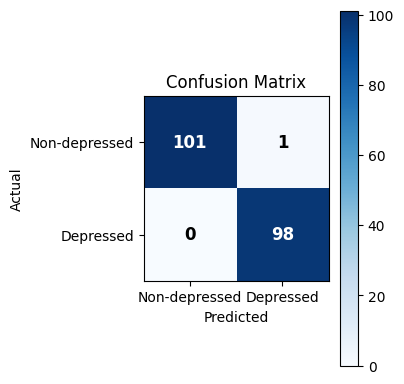

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


weight_mfcc = best_w  # e.g., 0.6

def ensemble_predict_id(file_path, weight_mfcc=weight_mfcc):
    p_m = mfcc_proba(file_path)
    p_w = w2v2_proba(file_path)
    p = weight_mfcc * p_m + (1.0 - weight_mfcc) * p_w
    return int(np.argmax(p))

y_true = test_df["label"].astype(int).tolist()
y_pred = [ensemble_predict_id(p) for p in test_df["file_path"].tolist()]

print("\nEnsemble Classification Report (Test):\n")
print(classification_report(
    y_true, y_pred,
    target_names=["Non-depressed", "Depressed"],
    digits=4
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Non-depressed", "Depressed"]
plt.xticks([0,1], classes)
plt.yticks([0,1], classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black",
                 fontsize=12, fontweight="bold")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Final Submission

In [23]:
import os, glob, zipfile
import pandas as pd
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

TEAM_NAME = "TriVector"
RUN = "run1"

#  Dataset base 
BASE = "/kaggle/input/datasets/tahmimahoque/depression-detection-speech-dataset/Depression_det"

#  Malayalam test folder 
TEST_DIR = os.path.join(BASE, "Test_set_mal", "Test_set_mal")


FINAL_DIR = "/kaggle/working/w2v2_best"   

# Label mapping 
ID2LABEL = {0: 0, 1: 1}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

assert os.path.isdir(TEST_DIR), f"Missing test dir: {TEST_DIR}"
assert os.path.isdir(FINAL_DIR), f"Missing model dir: {FINAL_DIR}"

# Collect test wavs
test_files = sorted(glob.glob(os.path.join(TEST_DIR, "**", "*.wav"), recursive=True))
print(" Test wavs:", len(test_files))
assert len(test_files) > 0, "No .wav found in TEST_DIR"

# Load model + processor
model = Wav2Vec2ForSequenceClassification.from_pretrained(FINAL_DIR).to(device)
processor = Wav2Vec2Processor.from_pretrained(FINAL_DIR)
model.eval()

@torch.no_grad()
def predict_label(file_path, sr=16000, max_seconds=6.0):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    max_len = int(sr * max_seconds)
    if len(y) > max_len:
        y = y[:max_len]

    inputs = processor([y], sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    logits = model(**inputs).logits
    pred_id = int(torch.argmax(logits, dim=-1).item())
    return ID2LABEL[pred_id]

# Predict
rows = []
for fp in test_files:
    file_id = os.path.splitext(os.path.basename(fp))[0]  # no .wav
    rows.append({"file_name": file_id, "label": predict_label(fp)})

mal_df = pd.DataFrame(rows)

# Save CSV in Kaggle working
csv_name = f"{TEAM_NAME}_Malayalam_{RUN}.csv"
csv_path = os.path.join("/kaggle/working", csv_name)
mal_df.to_csv(csv_path, index=False)
print(" CSV saved:", csv_path)
print(mal_df.head())


zip_name = f"{TEAM_NAME}_Malayalam_{RUN}.zip"
zip_path = os.path.join("/kaggle/working", zip_name)

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(csv_path, arcname=csv_name)

print(" ZIP saved:", zip_path)

Device: cuda
 Test wavs: 200


Loading weights:   0%|          | 0/215 [00:00<?, ?it/s]

 CSV saved: /kaggle/working/TriVector_Malayalam_run1.csv
  file_name  label
0        m1      1
1       m10      0
2      m100      1
3      m101      0
4      m102      1
 ZIP saved: /kaggle/working/TriVector_Malayalam_run1.zip


In [24]:
import pandas as pd

csv_path = "/kaggle/working/TriVector_Malayalam_run1.csv"  # existing CSV

df = pd.read_csv(csv_path)

# 0/1 → text labels
df["label"] = df["label"].map({0: "Non-depressed", 1: "Depressed"})

# overwrite same file
df.to_csv(csv_path, index=False)

print(" Converted to text labels:", csv_path)
print(df.head())

 Converted to text labels: /kaggle/working/TriVector_Malayalam_run1.csv
  file_name          label
0        m1      Depressed
1       m10  Non-depressed
2      m100      Depressed
3      m101  Non-depressed
4      m102      Depressed
